In [3]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

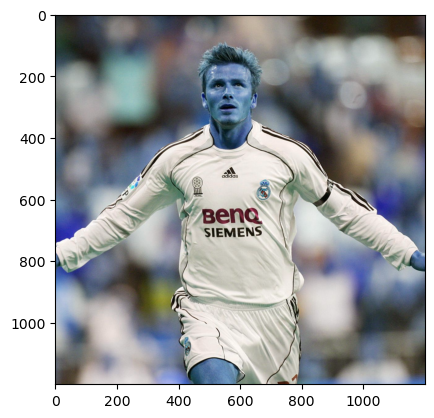

In [4]:
img = cv2.imread(r'./test_images/David Beckham.jpeg')
plt.imshow(img)

In [5]:
# loads cascade files
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

# define gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces
# displays the coordinates in (x,y,w,h) format

array([[472, 158, 181, 181]], dtype=int32)

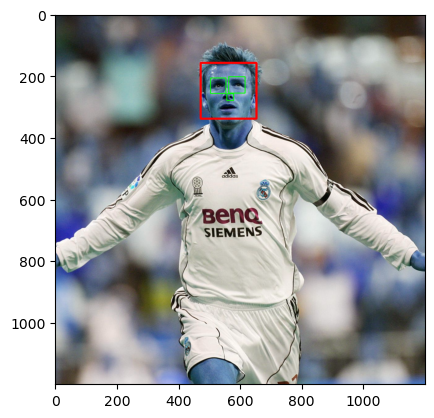

In [6]:
# obtaied from the opencv website
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

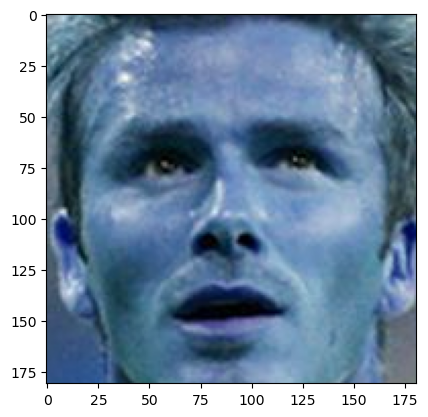

In [7]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is not None: 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color # if an image has 2 faces then this function will only store the first one
        
cropped_image = get_cropped_image_if_2_eyes(r'./test_images/David Beckham.jpeg')
plt.imshow(cropped_image)

# Data Cleaning

In [8]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

import os
img_dirs = []
for entry in os.scandir(path_to_data): # iterates through all subdirectories in the dataset folder
    if entry.is_dir():
        img_dirs.append(entry.path) # stores the names in this variable
        
import shutil
if os.path.exists(path_to_cr_data): 
     shutil.rmtree(path_to_cr_data) # deletes existing cropped folder (so that no duplicates exist in reruns)
os.mkdir(path_to_cr_data) # creates a variable with that name in the cropped folder

In [9]:
cropped_image_dirs = []
galactico_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    galactico_name = img_dir.split('/')[-1]
    
    galactico_file_names_dict[galactico_name] = []
    
    for entry in os.scandir(img_dir): # iterates through all the images in the folder
        # roi is region of interest
        roi_color = get_cropped_image_if_2_eyes(entry.path) # calls function on images where both eyes are visible
        if roi_color is not None: 
            # function has no output if both eyes are not visible
            cropped_folder = path_to_cr_data + galactico_name # creates folder name
            if not os.path.exists(cropped_folder): # if folder with that name does not exist then it creates it
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder) # appends folder name to the list
                print("Generating cropped images in folder: ",cropped_folder)

            # creates name of the cropped images and folders
            cropped_file_name = galactico_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            # stores cropped image in correct directory
            cv2.imwrite(cropped_file_path, roi_color)
            # creates dictionary which stores which images are in which folder
            galactico_file_names_dict[galactico_name].append(cropped_file_path)
            count += 1  

Generating cropped images in folder:  ./dataset/cropped/beckham
Generating cropped images in folder:  ./dataset/cropped/ronaldo
Generating cropped images in folder:  ./dataset/cropped/bale
Generating cropped images in folder:  ./dataset/cropped/casillas
Generating cropped images in folder:  ./dataset/cropped/zidane


# Pre processing (Feature Engineering)
now we will use wavlet transform to extract the distinct facial features

In [10]:
import numpy as np
import pywt
import cv2    

# obtained from stack overflow
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

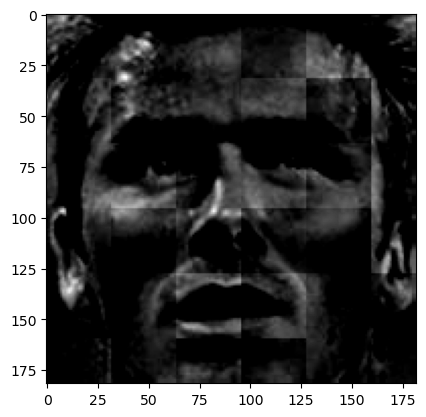

In [11]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [12]:
class_dict = {}
count = 0
for galactico_name in galactico_file_names_dict.keys():
    if galactico_name == 'cropped':
        continue
    class_dict[galactico_name] = count
    count = count + 1
class_dict

{'beckham': 0, 'ronaldo': 1, 'bale': 2, 'casillas': 3, 'zidane': 4}

In [37]:
X, y = [], []
for galactico_name, training_files in galactico_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image) 
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[galactico_name])     

[ WARN:0@15055.072] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./dataset/cropped/beckham/beckham2.png'): can't open/read file: check file path/integrity
[ WARN:0@15055.105] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./dataset/cropped/beckham/beckham7.png'): can't open/read file: check file path/integrity
[ WARN:0@15055.212] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./dataset/cropped/beckham/beckham17.png'): can't open/read file: check file path/integrity
[ WARN:0@15055.220] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./dataset/cropped/beckham/beckham19.png'): can't open/read file: check file path/integrity
[ WARN:0@15055.310] global /Users/runner/work/opencv-python/opencv

In [50]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(183, 4096)

# model training

In [39]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [40]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=2, return_train_score=False)
    clf.fit(X_train, y_train) #the data being scored here is the training data
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.656756,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.518436,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.693308,{'logisticregression__C': 1}


In [41]:
best_estimators['svm'].score(X_test,y_test)  #the data being scored here is the test data
# I will still use logistic_regression because it had the highest score in the cross validation

0.7391304347826086

In [51]:
best_clf = best_estimators['logistic_regression']

Text(95.72222222222221, 0.5, 'Truth')

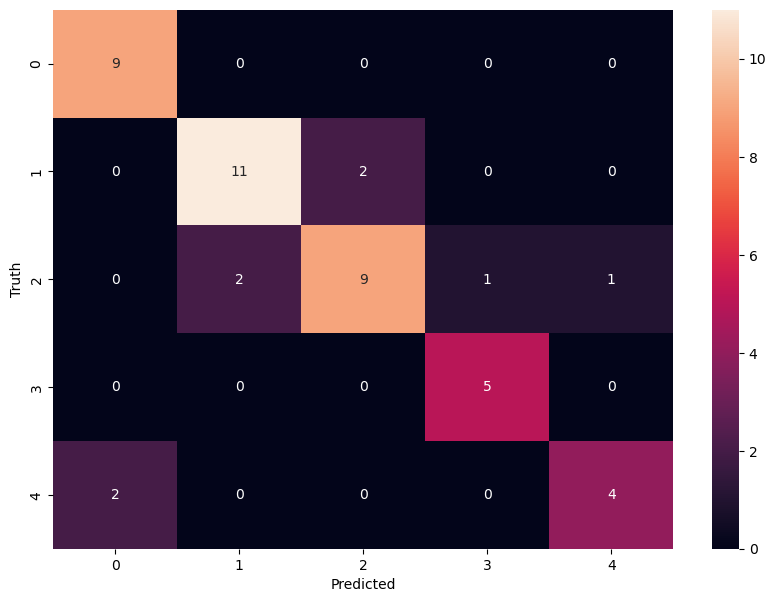

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [48]:
!pip install joblib
import joblib 
# saves the model as a pickle file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [49]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))